<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/jvcqp2iy2jlx2b32rmzdt0tx8lvxgzkp.png" width = 300, align = "center"></a>

<h1 align=center><font size = 5>RECOMMENDATION SYSTEM WITH A RESTRICTED BOLTZMANN MACHINE</font></h1>

Welcome to the **Recommendation System with a Restricted Boltzmann Machine** notebook. In this notebook, we study and go over the usage of a Restricted Boltzmann Machine (RBM) in a Collaborative Filtering based recommendation system. This system is an algorithm that recommends items by trying to find users that are similar to each other based on their item ratings. By the end of this notebook, you should have a deeper understanding of how Restricted Boltzmann Machines are applied, and how to build one using TensorFlow.

### Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
- <p><a href="#ref1">Acquiring the Data</a></p>
- <p><a href="#ref2">Loading in the Data</a></p>
- <p><a href="#ref3">The Restricted Boltzmann Machine model</a></p>
- <p><a href="#ref4">Setting the Model's Parameters</a></p>
- <p><a href="#ref1337">Recommendation</a></p>
<p></p>
</div>
<br>

----------

<a id="ref1"></a>
# Acquiring the Data

To start, we need to download the data we are going to use for our system. The datasets we're going to use were acquired by [GroupLens](http://grouplens.org/datasets/movielens/) and contain movies, users and movie ratings by these users.

After the download is done, we extract the datasets to a directory that's easily accessible.

In [2]:
#!wget -O ./data/moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ./data/moviedataset.zip -d ./data

Archive:  ./data/moviedataset.zip
   creating: ./data/ml-1m/
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


With the datasets in place, let's now import the necessary libraries. We will be using [Tensorflow](https://www.tensorflow.org/) and [Numpy](http://www.numpy.org/) together to model and initialize our Restricted Boltzmann Machine and [Pandas](http://pandas.pydata.org/pandas-docs/stable/) to manipulate our datasets. To import these libraries, run the code cell below.

In [1]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

-------------

<a id="ref2"></a>
# Loading in the Data

Let's begin by loading in our data with Pandas. The .dat files containing our data are similar to CSV files, but instead of using the ',' (comma) character to separate entries, it uses '::' (two colons) characters instead. To let Pandas know that it should separate data points at every '::', we have to specify the `sep='::'` parameter when calling the function.

Additionally, we also pass it the `header=None` parameter due to the fact that our files don't contain any headers.

Let's start with the movies.dat file and take a look at its structure:

In [2]:
#Loading in the movies dataset
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None)
movies_df.head()

/home/toedtli/.virtualenvs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We can do the same for the ratings.dat file:

In [3]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None)
ratings_df.head()

/home/toedtli/.virtualenvs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So our movies_df variable contains a dataframe that stores a movie's unique ID number, title and genres, while our ratings_df variable stores a unique User ID number, a movie's ID that the user has watched, the user's rating to said movie and when the user rated that movie.

Let's now rename the columns in these dataframes so we can better convey their data more intuitively:

In [4]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

Here's our final movies_df:

In [5]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


And our final ratings_df:

In [6]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


-----------

<a id="ref3"></a>
# The Restricted Boltzmann Machine model

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width = 300>

The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1 -- 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that the input hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

## Formatting the Data

First let's see how many movies we have and see if the movie ID's correspond with that value:

In [7]:
len(movies_df)

3883

In [8]:
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


As it is possible to notice, we have 3883 movies, while our ID's vary from 1 to 3952. Due to this, we won't be able to index movies through their ID since we would get memory indexing errors. To amend this, we can create a column that shows what spot in our list that particular movie is in:

In [9]:
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


With that, let's merge the ratings dataframe into the movies one so we can have the List Index values in both dataframes. Additionally we're also going to drop the Timestamp, Title and Genres columns since we won't be needing it to make recommendations.

In [10]:
#Merging movies_df with ratings_df by MovieID
merged_df = movies_df.merge(ratings_df, on='MovieID')
#Dropping unecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
#Displaying the result
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


Let's also group up the users by their user IDs and take a look at one of them.

In [11]:
#Group up by UserID
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into a list of lists called trX.

In [12]:
#Amount of users used for training
amountOfUsedUsers = 1000
#Creating the training list
trX = []
#For each user in the group
for userID, curUser in userGroup:
    #Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)
    #For each movie in curUser's movie list
    for num, movie in curUser.iterrows():
        #Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0
    #Now add the list of ratings into the training list
    trX.append(temp)
    #Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

------------

<a id="ref4"></a>
# Setting the Model's Parameters

Next, let's start building our RBM with Tensorflow. We'll begin by first determining the amount of hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connect the hidden layer with the visible one. We will be arbitrarily setting the amount of hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [16]:
hiddenUnits = 20
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the `tf.sigmoid` and `tf.relu` functions as nonlinear activations since it's what is usually used in RBM's.

In [17]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Now we set the RBM training parameters and functions.

In [18]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

And set the error function, which in this case will be the Mean Absolute Error Function.

In [19]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

We also have to initialize our variables. Thankfully, NumPy has a handy `zeros` function for this. We use it like so:

In [20]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now we train the RBM with 15 epochs with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch.

0.12363791
0.08270271
0.06833359
0.06103701
0.054537974
0.048469063
0.04579864
0.0444288
0.043785542
0.043072622
0.042412493
0.04185502
0.04147388
0.04099744
0.040577106


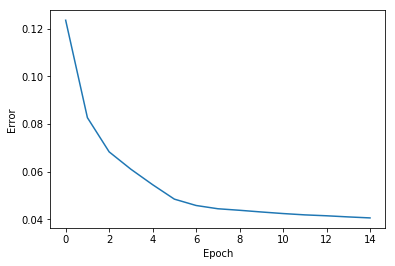

In [21]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

--------------

<a id="ref1337"></a>
## Recommendation

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

In [22]:
#Selecting the input user
inputUser = [trX[75]]

In [23]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [24]:
scored_movies_df_75 = movies_df
scored_movies_df_75["Recommendation Score"] = rec[0]
scored_movies_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.732231
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.650263
523,527,Schindler's List (1993),Drama|War,523,0.640392
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.626296
1245,1265,Groundhog Day (1993),Comedy|Romance,1245,0.550006
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.506625
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.503685
352,356,Forrest Gump (1994),Comedy|Romance|War,352,0.455335
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.453949
2928,2997,Being John Malkovich (1999),Comedy,2928,0.447470


So, how to recommend the movies that the user has not watched yet? 

Lets first find the __User ID__ of our mock user:

In [25]:
merged_df.iloc[75]

MovieID         1
List Index      0
UserID        215
Rating          4
Name: 75, dtype: int64

Now, we can find all the movies that our mock user has watched before:

In [26]:
movies_df_75 = merged_df[merged_df['UserID']==215]
movies_df_75.head()

,MovieID,List Index,UserID,Rating
75,1,0,215,4
11873,24,23,215,5
67543,260,257,215,5
82782,316,313,215,4
97063,356,352,215,5


In the next cell, we merge all the movies that our mock users has watched with the predicted scors based on his historical data:

In [27]:
#Merging movies_df with ratings_df by MovieID
merged_df_75 = scored_movies_df_75.merge(movies_df_75, on='MovieID', how='outer')
#Dropping unecessary columns
merged_df_75 = merged_df_75.drop('List Index_y', axis=1).drop('UserID', axis=1)

lets sort it and take a look at the firt 20 rows:

In [28]:
merged_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.732231,NaN
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.650263,NaN
523,527,Schindler's List (1993),Drama|War,523,0.640392,NaN
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.626296,NaN
1245,1265,Groundhog Day (1993),Comedy|Romance,1245,0.550006,NaN
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.506625,NaN
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.503685,NaN
352,356,Forrest Gump (1994),Comedy|Romance|War,352,0.455335,5.0
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.453949,4.0
2928,2997,Being John Malkovich (1999),Comedy,2928,0.447470,NaN


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to user.

This is the end of the module. If you want, you can try to change the parameters in the code -- adding more units to the hidden layer, changing the loss functions or maybe something else to see if it changes anything. Does the model perform better? Does it take longer to compute?

Thank you for reading this notebook. Hopefully, you now have a little more understanding of the RBM model, its applications and how it works with TensorFlow.

## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/ML0120EN_PAI).

Also, you can use Data Science Experience to run these notebooks faster with bigger datasets. Data Science Experience is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, DSX enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of DSX users today with a free account at [Data Science Experience](https://cocl.us/ML0120EN_DSX)This is the end of this lesson. Hopefully, now you have a deeper and intuitive understanding regarding the LSTM model. Thank you for reading this notebook, and good luck on your studies.

### Thank you for completing this exercise!

Notebook created by: Gabriel Garcez Barros Sousa, <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, <a href = "https://www.linkedin.com/in/franciscomagioli">Francisco Magioli</a>

## References
* [Restricted Boltzmann Machines for Collaborative Filtering](http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf)
* <font='red'>RBM Notebook</font>

<hr>
Copyright &copy; 2017 [IBM Cognitive Class](https://cocl.us/ML0120EN_cclab_cc). This notebook and its source code are released under the terms of the [MIT License](https://cognitiveclass.ai/mit-license/).